# Thin Gaussian Shells with Uniform Prior

This is a toy model shows how Nested Sampling easily handles likelihoods with multimodal behaviour.

$L(x) = P(y | x) = \log(e^{f(x,c_1,r_1,w_1)} + e^{f(x,c_2,r_2,w_2)}) $

where $f(x,c,r,w) = -\frac{1}{2 w^2}(|x - c| - r)^2 - \log(\sqrt(2 \pi w^2))$

and

$P(x) = \mathcal{U}[x \mid -6, 6 \pi]$.

In [121]:
from jax.config import config

config.update("jax_enable_x64", True)

import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import DefaultNestedSampler
from jaxns import Model
from jaxns import Prior
from jaxns import bruteforce_evidence

tfpd = tfp.distributions

In [122]:



def log_likelihood(theta):
    def log_circ(theta, c, r, w):
        return -0.5 * (jnp.linalg.norm(theta - c) - r) ** 2 / w ** 2 - jnp.log(jnp.sqrt(2 * jnp.pi * w ** 2))

    w1 = w2 = jnp.array(0.1)
    r1 = r2 = jnp.array(2.)
    c1 = jnp.array([0., -3.])
    c2 = jnp.array([0., 3.])
    return jnp.logaddexp(log_circ(theta, c1, r1, w1), log_circ(theta, c2, r2, w2))


def prior_model():
    x = yield Prior(tfpd.Uniform(low=-6. * jnp.ones(2), high=6. * jnp.ones(2)), name='theta')
    return x


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)

log_Z_true = bruteforce_evidence(model=model, S=250)
print(f"True log(Z)={log_Z_true}")

True log(Z)=-1.7456418720467646


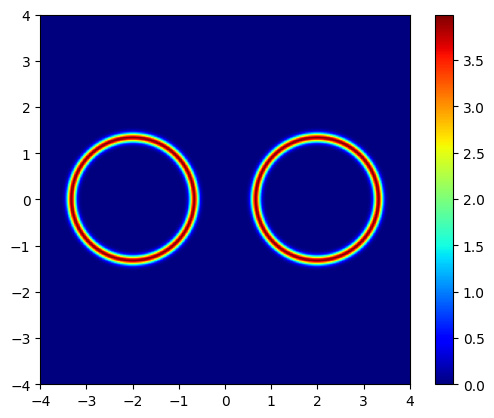

In [123]:

u_vec = jnp.linspace(0., 1., 250)
args = jnp.stack([x.flatten() for x in jnp.meshgrid(*[u_vec] * model.U_ndims, indexing='ij')], axis=-1)

# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(model.forward)(args).reshape((u_vec.size, u_vec.size))

plt.imshow(jnp.exp(lik), origin='lower', extent=(-4, 4, -4, 4), cmap='jet')
plt.colorbar()
plt.show()

In [124]:


# Create the nested sampler class. In this case without any tuning.
exact_ns = DefaultNestedSampler(model=model, max_samples=1e5, k=0, s=5, c=model.U_ndims * 100)

termination_reason, state = exact_ns(random.PRNGKey(42))
results = exact_ns.to_results(termination_reason=termination_reason, state=state)


In [125]:
# We can use the summary utility to display results
exact_ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 189394
samples: 2600
phantom samples: 0
likelihood evals / sample: 72.8
phantom fraction (%): 0.0%
--------
logZ=-1.92 +- 0.12
H=-2.75
ESS=319
--------
theta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
theta[0]: -0.0 +- 1.5 | -2.0 / -0.0 / 1.8 | -1.7 | -1.7
theta[1]: 0.5 +- 3.2 | -4.1 / 1.1 / 4.7 | 2.0 | 2.0
--------


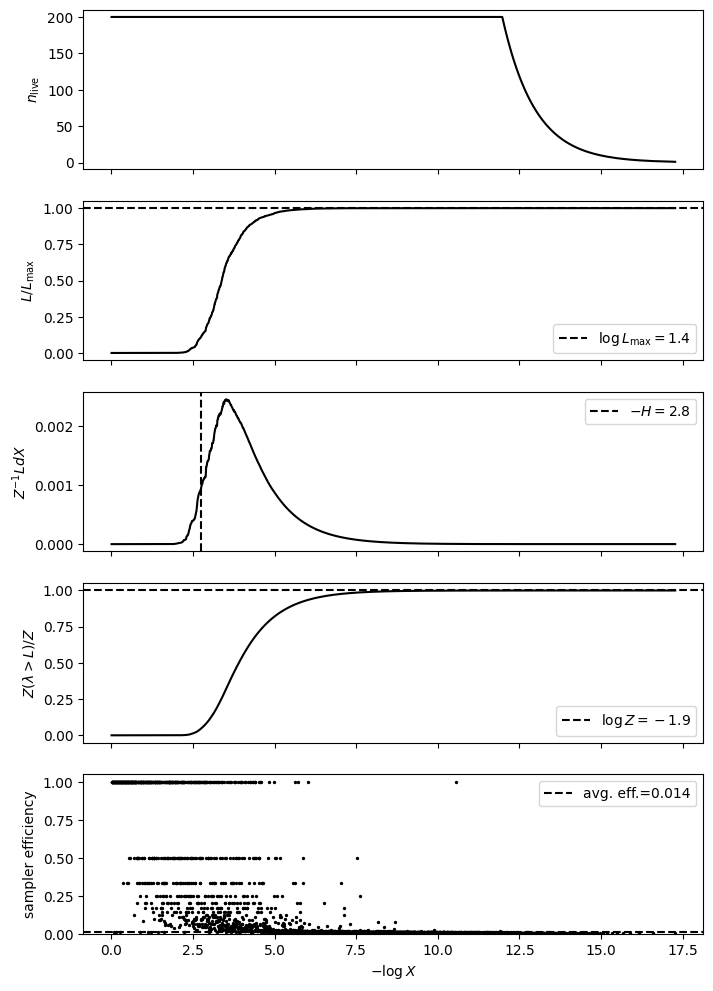

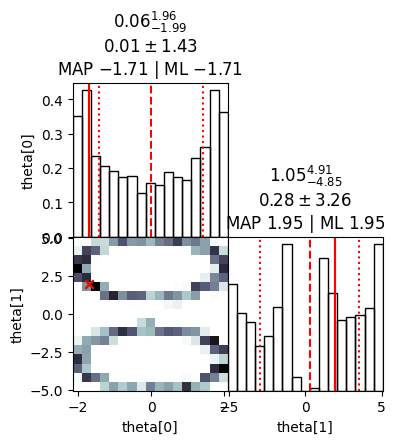

In [126]:
# We plot useful diagnostics and a distribution cornerplot
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)